In [ ]:
# Step 1: Install necessary package (if not already available)
!pip install openpyxl

# Step 2: Import required libraries
import pandas as pd

# Step 3: Set file path (adjust if in a different folder in Colab)
file_path = "/content/rawMeterData-123W93Street.xls"

# Step 4: Read all four sheets
sheet_names = ['2021', '2022', '2023', '2024']

dfs = []
for sheet in sheet_names:
    df = pd.read_excel(file_path, sheet_name=sheet)
    dfs.append(df)

# Step 5: Combine all sheets into one DataFrame
combined_df = pd.concat(dfs, ignore_index=True)

# Step 6: Preview the combined data
print("Combined shape:", combined_df.shape)
combined_df.head()


Combined shape: (131424, 3)


,dateTimeStmp,raw_MM_Wh,raw_Tenant_Wh
0,2021-01-01 00:00:00,9516.17,6829.72
1,2021-01-01 00:15:00,8710.08,6124.53
2,2021-01-01 00:30:00,8123.25,6243.97
3,2021-01-01 00:45:00,8097.63,6234.43
4,2021-01-01 01:00:00,9140.92,6313.70


In [ ]:
combined_df.to_csv("combined_meter_data.csv", index=False)


In [ ]:
combined_df.head()

,dateTimeStmp,raw_MM_Wh,raw_Tenant_Wh
0,2021-01-01 00:00:00,9516.17,6829.72
1,2021-01-01 00:15:00,8710.08,6124.53
2,2021-01-01 00:30:00,8123.25,6243.97
3,2021-01-01 00:45:00,8097.63,6234.43
4,2021-01-01 01:00:00,9140.92,6313.70


In [ ]:
# Step 7: Ensure datetime column is in datetime format
combined_df['dateTimeStmp'] = pd.to_datetime(combined_df['dateTimeStmp'])

# Step 8: Sort just to be sure (chronological order)
combined_df = combined_df.sort_values('dateTimeStmp').reset_index(drop=True)

# Step 9: Add a binary flag column to mark where raw_MM_Wh == 0
combined_df['is_zero'] = (combined_df['raw_MM_Wh'] == 0).astype(int)

# Step 10: Detect continuous sequences (gaps) of zero values
# We'll assign a group number that increments when a zero sequence breaks
# The cumsum over (not zero) helps us create groupings
combined_df['zero_group'] = (combined_df['is_zero'] != combined_df['is_zero'].shift()).cumsum()
zero_gaps = combined_df[combined_df['is_zero'] == 1].groupby('zero_group').agg(
    start_time=('dateTimeStmp', 'first'),
    end_time=('dateTimeStmp', 'last'),
    length=('is_zero', 'count')
).reset_index(drop=True)

# Step 11: Print a summary
print("Total zero-value readings:", combined_df['is_zero'].sum())
print("Number of zero gaps:", len(zero_gaps))
zero_gaps.head()


Total zero-value readings: 3615
Number of zero gaps: 631


,start_time,end_time,length
0,2021-07-06 19:45:00,2021-07-07 11:15:00,63
1,2021-08-24 21:30:00,2021-09-14 15:30:00,1993
2,2021-10-20 16:00:00,2021-10-20 16:00:00,1
3,2021-10-21 07:30:00,2021-10-21 07:30:00,1
4,2021-10-22 22:00:00,2021-10-22 22:00:00,1


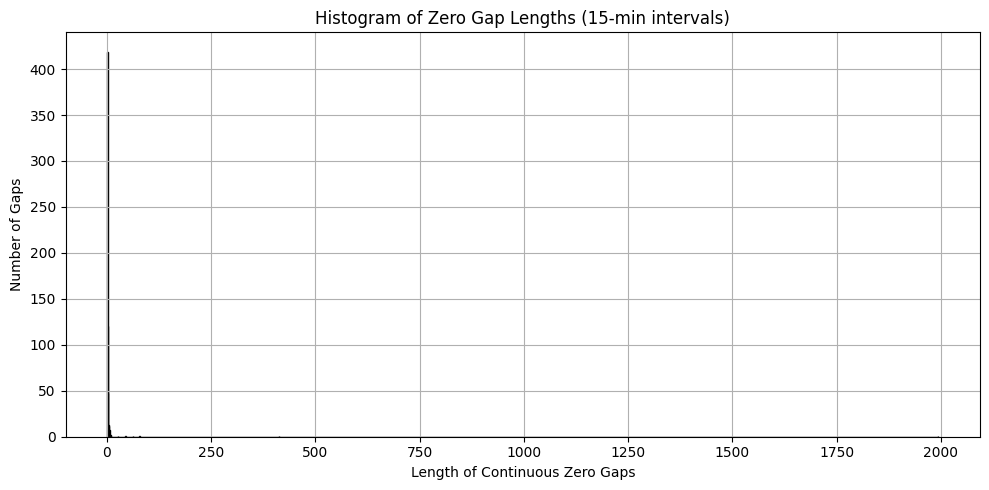

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.hist(zero_gaps['length'], bins=range(1, zero_gaps['length'].max()+2), edgecolor='black')
plt.title("Histogram of Zero Gap Lengths (15-min intervals)")
plt.xlabel("Length of Continuous Zero Gaps")
plt.ylabel("Number of Gaps")
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
zero_gaps.describe()

,start_time,end_time,length
count,631,631,631.000000
mean,2022-03-01 11:43:47.258320128,2022-03-01 12:54:43.359746304,5.729002
min,2021-07-06 19:45:00,2021-07-07 11:15:00,1.000000
25%,2022-02-17 23:45:00,2022-02-18 00:00:00,1.000000
50%,2022-03-08 22:15:00,2022-03-08 22:30:00,1.000000
75%,2022-03-21 03:45:00,2022-03-21 03:52:30,2.000000
max,2024-10-29 10:30:00,2024-10-29 12:15:00,1993.000000
std,NaN,NaN,81.027162


In [ ]:
# Step 12: Create a date column for grouping
combined_df['date'] = combined_df['dateTimeStmp'].dt.date

# Step 13: Daily zero count
daily_zeros = combined_df.groupby('date')['is_zero'].sum().reset_index()
daily_zeros.columns = ['date', 'zero_count']

# Step 14: Normalize by number of expected readings per day (should be 96 for 15-min intervals)
expected_per_day = 96
daily_zeros['zero_percent'] = (daily_zeros['zero_count'] / expected_per_day) * 100
daily_zeros['date'] = pd.to_datetime(daily_zeros['date'])  # back to datetime for plotting


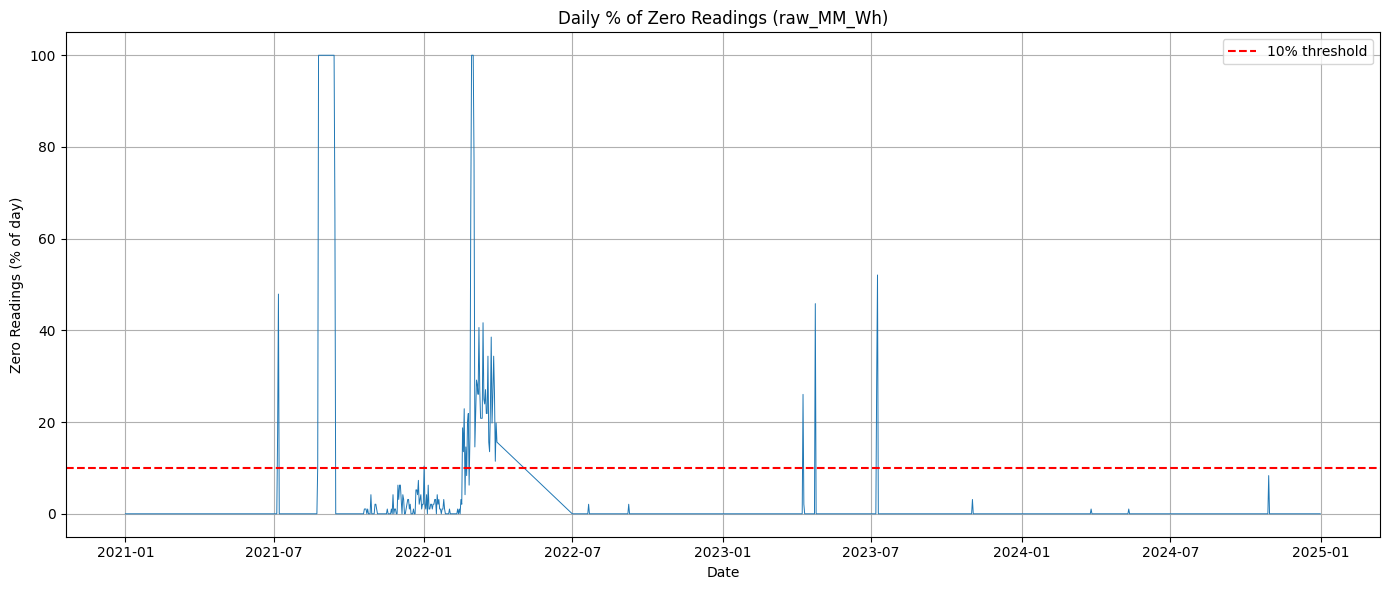

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,6))
plt.plot(daily_zeros['date'], daily_zeros['zero_percent'], lw=0.7)
plt.axhline(10, color='red', linestyle='--', label='10% threshold')
plt.title("Daily % of Zero Readings (raw_MM_Wh)")
plt.xlabel("Date")
plt.ylabel("Zero Readings (% of day)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


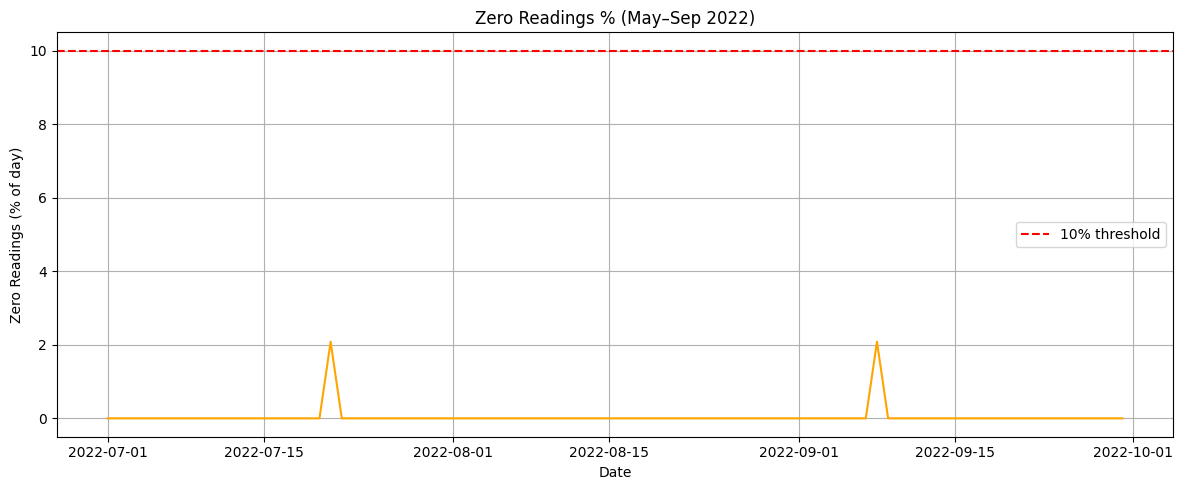

In [ ]:
suspect_period = daily_zeros[
    (daily_zeros['date'] >= '2022-05-01') &
    (daily_zeros['date'] <= '2022-09-30')
]

plt.figure(figsize=(12,5))
plt.plot(suspect_period['date'], suspect_period['zero_percent'], color='orange')
plt.axhline(10, color='red', linestyle='--', label='10% threshold')
plt.title("Zero Readings % (May–Sep 2022)")
plt.xlabel("Date")
plt.ylabel("Zero Readings (% of day)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Filter out all rows with zero energy readings
nonzero_df = combined_df[combined_df['raw_MM_Wh'] != 0].copy()

# Focus on 2023 and 2024 only
nonzero_df = nonzero_df[
    (nonzero_df['dateTimeStmp'].dt.year >= 2023) &
    (nonzero_df['dateTimeStmp'].dt.year <= 2024)
].reset_index(drop=True)

# Preview
print("NONZERO_SUBSET shape:", nonzero_df.shape)
nonzero_df.head()


NONZERO_SUBSET shape: (69918, 6)


,dateTimeStmp,raw_MM_Wh,raw_Tenant_Wh,is_zero,zero_group,date
0,2023-01-01 00:00:00,7993.92,5970.00,0,1249,2023-01-01
1,2023-01-01 00:15:00,7760.30,5674.25,0,1249,2023-01-01
2,2023-01-01 00:30:00,7924.57,5721.50,0,1249,2023-01-01
3,2023-01-01 00:45:00,8126.38,5802.72,0,1249,2023-01-01
4,2023-01-01 01:00:00,7492.17,5129.45,0,1249,2023-01-01


In [ ]:
# Add hour-bucket column for grouping (rounds down to the hour)
nonzero_df['hour'] = nonzero_df['dateTimeStmp'].dt.floor('H')


<ipython-input-11-6a9bfa3665f3>:2: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  nonzero_df['hour'] = nonzero_df['dateTimeStmp'].dt.floor('H')


In [ ]:
# Group by hour and count how many intervals per hour
interval_counts = nonzero_df.groupby('hour')['raw_MM_Wh'].count()

# Only include hours where all 4 intervals exist (i.e., complete hour)
valid_hours = interval_counts[interval_counts == 4].index

# Filter to those hours
valid_hourly_df = nonzero_df[nonzero_df['hour'].isin(valid_hours)]

# Now group and sum per hour
hourly_df = valid_hourly_df.groupby('hour').agg({
    'raw_MM_Wh': 'sum',
    'raw_Tenant_Wh': 'sum'
}).reset_index().rename(columns={'hour': 'dateTimeStmp'})

# Preview result
print("Hourly data shape:", hourly_df.shape)
hourly_df.head()


Hourly data shape: (17470, 3)


,dateTimeStmp,raw_MM_Wh,raw_Tenant_Wh
0,2023-01-01 00:00:00,31805.17,23168.47
1,2023-01-01 01:00:00,27381.22,19302.73
2,2023-01-01 02:00:00,25207.58,17440.27
3,2023-01-01 03:00:00,23207.99,15739.71
4,2023-01-01 04:00:00,21702.68,14349.58


In [ ]:
# All possible hourly buckets from NONZERO_SUBSET
all_hours = nonzero_df['hour'].nunique()

# How many full hours we kept (i.e., hours with 4 non-zero intervals)
kept_hours = len(hourly_df)

# % of hours retained
retention_rate = (kept_hours / all_hours) * 100

print(f"Total hourly periods (2023–24): {all_hours}")
print(f"Kept (valid) hourly periods: {kept_hours}")
print(f"Retention rate: {retention_rate:.2f}%")
print(f"Dropped hours: {all_hours - kept_hours}")


Total hourly periods (2023–24): 17482
Kept (valid) hourly periods: 17470
Retention rate: 99.93%
Dropped hours: 12


In [ ]:
# Rebuild expected_hours using hour buckets seen in nonzero_df (more accurate)
expected_hours = nonzero_df['hour'].drop_duplicates().sort_values()

existing_hours = set(hourly_df['dateTimeStmp'])
missing_hours = [h for h in expected_hours if h not in existing_hours]

print(f"Missing hours to backfill: {len(missing_hours)}")


Missing hours to backfill: 12


In [ ]:
# Copy hourly_df to build the final backfilled DataFrame
hourly_backfilled_df = hourly_df.copy()

# Loop over each missing hour
for h in missing_hours:
    # Generate candidate timestamps for ±3 days
    neighbor_hours = [(h - pd.Timedelta(days=d)) for d in range(1, 4)] + \
                     [(h + pd.Timedelta(days=d)) for d in range(1, 4)]

    # Filter for neighbors that exist in current data
    neighbor_data = hourly_df[hourly_df['dateTimeStmp'].isin(neighbor_hours)]

    if len(neighbor_data) >= 2:  # Only backfill if we have enough context
        avg_mm = neighbor_data['raw_MM_Wh'].mean()
        avg_tenant = neighbor_data['raw_Tenant_Wh'].mean()

        # Create new row
        filled_row = pd.DataFrame([{
            'dateTimeStmp': h,
            'raw_MM_Wh': avg_mm,
            'raw_Tenant_Wh': avg_tenant
        }])

        # Append to the main DataFrame
        hourly_backfilled_df = pd.concat([hourly_backfilled_df, filled_row], ignore_index=True)

# Sort by time
hourly_backfilled_df = hourly_backfilled_df.sort_values('dateTimeStmp').reset_index(drop=True)

# Final check
print("Hourly shape after backfilling:", hourly_backfilled_df.shape)


Hourly shape after backfilling: (17482, 3)


In [ ]:
# Save final backfilled hourly consumption profile to CSV
hourly_backfilled_df.to_csv("hourly_consumption_backfilled_2023_2024.csv", index=False)
print("Saved: hourly_consumption_backfilled_2023_2024.csv")


Saved: hourly_consumption_backfilled_2023_2024.csv


In [ ]:
nonzero_df.to_csv("nonzero_subset_2023_2024.csv", index=False)
print(" Saved: nonzero_subset_2023_2024.csv")


 Saved: nonzero_subset_2023_2024.csv


In [ ]:
zero_gaps.to_csv("zero_gap_report.csv", index=False)


In [ ]:
print("\n Final Summary:")
print(f"Total hourly periods (expected): {all_hours}")
print(f"Kept before backfill: {kept_hours}")
print(f"Final shape after backfill: {hourly_backfilled_df.shape}")



 Final Summary:
Total hourly periods (expected): 17482
Kept before backfill: 17470
Final shape after backfill: (17482, 3)
